In [ ]:
# default_exp evaluation.core

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Evaluation

> API details.

In [8]:
# export
import numpy as np
import pandas as pd
import tensorflow as tf

from collections import Counter, defaultdict
from icodegen.model.core import Model

# from pathlib import Path
from statistics import mean
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from typing import Dict, List, Optional

In [31]:
from icodegen.model.core import TransformerModel

tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
trnsfr = TFGPT2LMHeadModel.from_pretrained("distilgpt2")
model = TransformerModel(tokenizer, trnsfr)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [47]:
df_fake = pd.DataFrame(
    ["aaaa(bb(aaaa(bb()()ccc)dd)()ccc)dd", "aaaa(bb()ccccc)dd"], columns=["code"]
)
df_fake

,code
0,aaaa(bb(aaaa(bb()()ccc)dd)()ccc)dd
1,aaaa(bb()ccccc)dd


In [162]:
# export
def get_mean_probs(df: pd.DataFrame, model: Model, n: Optional[int] = None):
    """
    Get the mean probability of each token that the model
    should predict for an entire pandas dataframe.

    :param df: the pandas dataframe containing each method to have the model predict on
    :param model: the model used to generate the predictions
    :param n: the number of methods to evaluate. If none, the entire dataframe will be used
    :returns: returns a numpy array of the mean probability for each token in the model's vocab
    """
    if n is None:
        n = len(df)

    # setup container lists for the number of occurrences and sum of probabilities for each token
    counts = [0] * len(model.tokenizer)
    sum_probs = [0.0] * len(model.tokenizer)
    # loop through each method
    for mthd in df.code.values[:n]:
        # token the method and generate the probabilities for the model's predictions
        inputs = model.tokenize(mthd)
        probs = model.get_probs(inputs)[0].numpy()

        # loop through each token and its probability and update the container lists
        for idx, p in zip(inputs["input_ids"][0], probs):
            counts[idx] += 1
            sum_probs[idx] += p[idx]

    # convert the lists to numpy lists and perform element wise division to get the mean probabilities for each token
    counts = np.array(counts)
    sum_probs = np.array(sum_probs)

    # perform division, but not when denominator is zero. In those cases, just leave value as NAN.
    nans = np.empty(counts.shape)
    nans.fill(np.nan)
    mean_probs = np.divide(sum_probs, counts, out=nans, where=counts != 0)
    return mean_probs

In [163]:
NON_NAN_PROBS_MEAN = np.array(
    [
        0.0016351,
        0.00323522,
        0.00401226,
        0.03455071,
        0.0278546,
        0.01272959,
        0.00626087,
        0.0742716,
    ]
)
mean_probs = get_mean_probs(df_fake, model)

non_nan_idx = np.argwhere(~np.isnan(mean_probs)).flatten()
non_nan_mean_prob = mean_probs[non_nan_idx]

assert np.isclose(non_nan_mean_prob, NON_NAN_PROBS_MEAN).all()

In [20]:
# export
def find_parens(toks: List[str], opening: str, closing: str) -> Dict[int, int]:
    """
    Get the indices for the opening and closing tokens. From https://stackoverflow.com/a/29992065/5768407.

    :param toks: the tokenized version of a method
    :param opening: the opening token that will be matched against the closing token
    :param closing: the closing token that will be matched against the opening token
    :returns: returns a dictionary with the opening token indices as the keys and the closing token indices as the values
    """
    toret = {}
    pstack = []

    for i, tok in enumerate(toks):
        if tok == opening:
            pstack.append(i)
        elif tok == closing:
            if len(pstack) == 0:
                raise IndexError("No matching closing parens at: " + str(i))
            toret[pstack.pop()] = i

    if len(pstack) > 0:
        raise IndexError("No matching opening parens at: " + str(pstack.pop()))

    return toret


def _get_dist_probs(
    mthd: str, model: Model, opening: str, closing: str
) -> Dict[int, float]:
    """
    Get the distances and mean probabilities between opening and closing tokens in a given method.

    :param mthd: the method to get the ranges of the opening and closing tokens and their probabilities
    :param model: the model used to generate the predictions
    :param opening: the opening token used for calculating the distance between opening and closing tokens
    :param closing: the closing token used for calculating the distance between opening and closing tokens as well as the token to get the mean probability of
    :returns: returns a dictionary with the distance between the opening and closing tokens as keys and their mean probabilities as values
    """
    # WARNING: Careful when using different tokenizers since HF tokenizers lib have diff API then HF transformers lib tokenizers... You will need to update this when using custom model and tokenizer...

    # get the distances for the opening and closing tokens
    toks = model.tokenizer.tokenize(mthd)
    idxs = find_parens(toks, opening, closing)

    # get the model probabilities for the given method
    inputs = model.tokenize(mthd)
    probs = model.get_probs(inputs)[0].numpy()

    # sum up the probabilities of the different distances for the closing token
    dist_probs = defaultdict(float)
    for o, c in idxs.items():
        dist_probs[c - o] += probs[c][inputs["input_ids"][0][c]]

    # get the mean of the summed probabilities
    dist_cnts = Counter([c - o for o, c in idxs.items()])
    dist_probs = {d: dist_probs[d] / n for d, n in dist_cnts.items()}
    return dist_probs


def mean_dist_probs(
    df: pd.DataFrame,
    model: Model,
    opening: Optional[str] = "<{>",
    closing: Optional[str] = "<}>",
    n: Optional[int] = None,
) -> pd.DataFrame:
    """
    Get the distance between opening and closing tokens and the mean probability of each closing token that the model should predict for an entire pandas dataframe.

    :param df: the pandas dataframe containing each method to have the model predict on
    :param model: the model used to generate the predictions
    :param opening: the opening token used for calculating the distance between opening and closing tokens
    :param closing: the closing token used for calculating the distance between opening and closing tokens as well as the token to get the mean probability of
    :param n: the number of methods to evaluate. If none, the entire dataframe will be used
    :returns: returns a dataframe with the distances between opening and closing tokens and their mean probabilities
    """
    if n is None:
        n = len(df)

    # get the probabilities for the different distances for an entire dataframe
    df = df.iloc[:n].copy()
    dist_probs = df.code.apply(
        lambda mthd: _get_dist_probs(mthd, model, opening, closing)
    ).values

    # flatten the keys of the different distances into a list
    l = []
    for probs in dist_probs:
        l.extend(probs.keys())

    print(dist_probs)
    # merge dictionaries across methods by taking the mean of probs with the same distance. From https://stackoverflow.com/a/10461916/5768407
    dist_probs = {k: mean([probs.get(k, 0) for probs in dist_probs]) for k in set(l)}
    df_dist = (
        pd.DataFrame(
            {"dist": list(dist_probs.keys()), "mean_prob": list(dist_probs.values())}
        )
        .sort_values("dist")
        .reset_index(drop=True)
    )
    return df_dist

In [30]:
DIST_DF = pd.DataFrame(
    {
        "dist": [6, 10, 16],
        "mean_prob": [
            0.00038048954229452647,
            0.0005513867363333702,
            0.0006684093968942761,
        ],
    }
)
df_dist = mean_dist_probs(df_fake, model, opening="(", closing=")")

assert (DIST_DF.dist.values == df_dist.dist.values).all()
assert np.isclose(DIST_DF.mean_prob.values, df_dist.mean_prob.values).all()

[{6: 0.0007226976449601352, 10: 0.0005513698561117053, 16: 0.0006684109685011208}
 {6: 3.830732384813018e-05}]


AssertionError: 

In [ ]:
df_dist.mean_prob.values[2]

0.00033420469844713807

<BarContainer object of 2 artists>

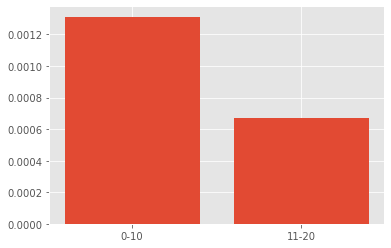

In [ ]:
# TODO: Need to move all these visualizations to their own module...
# TODO: make this binning process easier where I can just pass in some vars and it handles it for me
df_dist["bin"] = pd.cut(
    df_dist.dist, bins=[0, 10, 20], labels=["0-10", "11-20"], include_lowest=True
)
df_dist = df_dist.sort_values("dist")

bars = {}
for x in df_dist.bin.unique():
    bars[x] = sum(df_dist.loc[df_dist.bin == x].mean_prob.values)

plt.bar(bars.keys(), bars.values())

In [ ]:
# export
def get_mean_cross_entropy(df: pd.DataFrame, model: Model, n: Optional[int] = None):
    """
    Get the mean cross entropy for a model on an entire pandas dataframe

    :param df: the pandas dataframe containing each method to have the model predict on
    :param model: the model used to generate the predictions
    :param n: the number of methods to evaluate. If none, the entire dataframe will be used
    :returns: returns the mean cross entropy of the models predictions compared to true labels
    """
    if n is None:
        n = len(df)

    cross_entropy_losses = []
    bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    for mthd in df.code.values[:n]:
        # token the method and generate one hot encoding for the true labels
        inputs = model.tokenize(mthd)
        labels = np.zeros((len(inputs["input_ids"]), len(model.tokenizer)))
        labels[np.arange(len(inputs["input_ids"])), inputs["input_ids"].numpy()] = 1

        # get the probabilities for each token from the model
        probs = model.get_probs(inputs)[0].numpy()

        # calculate the cross entropy between the labels and probabilities
        cross_entropy = bce(labels, probs).numpy()
        cross_entropy_losses.append(cross_entropy)

    # flatten list of cross entropies and take the mean
    cross_entropy_losses = np.concatenate(cross_entropy_losses)
    return np.mean(cross_entropy_losses)

In [ ]:
mean_cross_entropy = get_mean_cross_entropy(df_fake, model)

inputs = model.tokenize(df_fake.code.values[0])
labels = np.zeros((len(inputs["input_ids"]), len(model.tokenizer)))
labels[np.arange(len(inputs["input_ids"])), inputs["input_ids"].numpy()] = 1

bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

probs = model.get_probs(inputs)[0].numpy()
cross_entropy = bce(labels, probs).numpy()

assert mean_cross_entropy == np.mean(cross_entropy)

In [ ]:
# hide
mean_cross_entropy = get_mean_cross_entropy(df_trn, model, n=100)
mean_cross_entropy

0.014070554